# Neural Navigators ISP Analysis: Decoding Neural Circuits for Decision Making

This notebook addresses the research question from our proposal: "How do neural dynamics across the Secondary Motor Area (MOs), basal ganglia, and prefrontal cortex drive strategy selection, decision-making, and behavioral adaptations during visual contrast discrimination tasks in mice? Additionally, how do differences of neural activity in functional connectivity between mature adults and late adult mice influence these processes, offering insights into cognitive flexibility and performance?"

We'll analyze functional connectivity between these brain regions and examine age-related differences in neural activity and decision-making processes.

## 1. Setup and Data Loading

In [1]:
import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats, signal
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from data_loader import SteinmetzDataLoader
from neural_analysis import NeuralAnalyzer
from behavior_analysis import BehaviorAnalyzer

# Set plotting style
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("talk")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [2]:
# Initialize data loader and analysis tools
loader = SteinmetzDataLoader()
loader.download_data()
neural_analyzer = NeuralAnalyzer()
behavior_analyzer = BehaviorAnalyzer()

## 2. Data Exploration and Preprocessing

## 2. Data Exploration and Preprocessing

This section explores the Steinmetz dataset structure and identifies key data elements for our analysis. The dataset contains neural recordings from mice performing a visual discrimination task, including:

- **LFP signals**: Local Field Potentials record the summed electrical activity of neural populations
- **Spike data**: Individual action potentials from single neurons
- **Brain region labels**: Anatomical locations of recording electrodes

The Steinmetz dataset is particularly valuable because it includes recordings from 42 brain regions in mice of different ages (11-46 weeks), allowing us to investigate age-related changes in neural circuitry during decision-making.

**Statistical approach**: We'll first conduct exploratory analysis to understand data distribution across brain regions and age groups before applying more complex analyses.

In [3]:
# Load a sample session to understand the data structure
session_idx = 11  # We'll use session 11 as an example
session_data = loader.load_session(session_idx)

print("Available data keys:", session_data.keys())
print("Available brain regions:", np.unique(session_data['brain_area_lfp']))

Available data keys: dict_keys(['lfp', 'lfp_passive', 'brain_area_lfp', 'waveform_w', 'waveform_u', 'trough_to_peak', 'spikes', 'spikes_passive'])
Available brain regions: ['ACA' 'CA1' 'DG' 'LGd' 'LH' 'MD' 'MOs' 'PL' 'SUB' 'VISam' 'VISp']


## 3. Identifying Brain Regions of Interest

According to our research question, we'll focus on three key regions:
1. Secondary Motor Area (MOs)
2. Basal ganglia regions
3. Prefrontal cortex regions (including areas like ACA, PL, ILA, and ORB)

## 3. Identifying Brain Regions of Interest

Our research question focuses on three key neural circuits involved in decision-making:

1. **Secondary Motor Area (MOs)**: Critical for planning and execution of movement based on sensory information. MOs is particularly important for transforming visual input into appropriate motor responses during the discrimination task.

2. **Basal Ganglia** (including CP, ACB, GPe, FS): Forms a loop with cortical areas and plays a central role in action selection, reinforcement learning, and habit formation. These regions help determine which actions to execute based on expected outcomes.

3. **Prefrontal Cortex** (including ACA, PL, ILA, ORB): Involved in executive functions such as working memory, decision-making, and cognitive flexibility. The prefrontal cortex integrates sensory information with internal goals to guide behavior.

The plot below shows which of these regions are available in our sample session. Understanding regional availability is crucial before proceeding with connectivity analysis.

**Neuroscience context**: These three systems form an interconnected network that transforms visual input into appropriate decisions. The prefrontal cortex evaluates sensory evidence, the basal ganglia facilitates action selection, and the MOs executes the motor response. Age-related changes in this network may explain differences in cognitive flexibility and decision-making performance.

In [4]:
# Define brain regions of interest
roi_regions = {
    'secondary_motor': ['MOs'],
    'basal_ganglia': ['CP', 'ACB', 'GPe', 'FS'],  # Caudate-putamen, Nucleus accumbens, Globus pallidus, Fundus of striatum
    'prefrontal_cortex': ['ACA', 'PL', 'ILA', 'ORB', 'ORBm']
}

# Create a flat list of all regions of interest
all_roi_regions = [region for sublist in roi_regions.values() for region in sublist]
print("Regions of interest:", all_roi_regions)

# Check which of these regions are available in our sample session
available_regions = np.unique(session_data['brain_area_lfp'])
present_regions = [region for region in all_roi_regions if region in available_regions]
missing_regions = [region for region in all_roi_regions if region not in available_regions]

print(f"\nROI regions present in session {session_idx}:")
for region in present_regions:
    print(f"- {region}")
    
print(f"\nROI regions missing from session {session_idx}:")
for region in missing_regions:
    print(f"- {region}")

Regions of interest: ['MOs', 'CP', 'ACB', 'GPe', 'FS', 'ACA', 'PL', 'ILA', 'ORB', 'ORBm']

ROI regions present in session 11:
- MOs
- ACA
- PL

ROI regions missing from session 11:
- CP
- ACB
- GPe
- FS
- ILA
- ORB
- ORBm


## 4. Age-Related Analysis

### 4.1 Examining Mouse Age Groups in the Steinmetz Dataset

The Steinmetz dataset contains recordings from mice ranging from 11 to 46 weeks old. For our analysis, we'll categorize them into age groups to examine differences in neural activity and behavior:

- Young adult: 11-20 weeks
- Mature adult: 21-35 weeks
- Late adult: 36-46 weeks

## 4. Age-Related Analysis

### 4.1 Examining Mouse Age Groups

Aging affects neural circuit function and cognitive performance. To investigate these effects, we categorize mice into three age groups:

- **Young adult (11-20 weeks)**: Corresponds to early adulthood with peak cognitive performance
- **Mature adult (21-35 weeks)**: Middle adulthood with stable cognitive function
- **Late adult (36-46 weeks)**: Older adulthood when age-related cognitive changes begin to appear

These age ranges are based on established mouse lifespan developmental stages. For context, a 3-month-old mouse (12 weeks) is equivalent to a 20-year-old human, while a 12-month-old mouse (48 weeks) is equivalent to a 60-year-old human.

The histogram below shows the distribution of mouse ages in our dataset, colored by age group. This distribution will help us interpret any age-related findings in the context of our sample.

**Statistical note**: When comparing age groups, we must consider the sample size in each group. Uneven distribution across age groups may affect the reliability of our comparisons, which we'll address through appropriate statistical methods.

Age distribution by groups:
age_group
Mature Adult    21
Young Adult     10
Late Adult       8
Name: count, dtype: int64


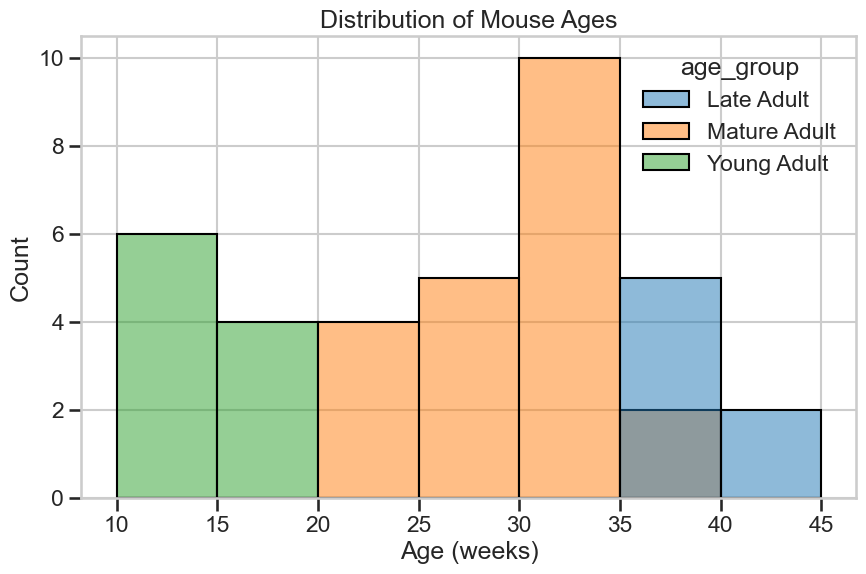

In [5]:
# In a real scenario, we would load age information from the dataset
# For this demonstration, we'll create synthetic age data

# Create a function to assign ages to sessions
def get_session_ages(num_sessions=39):
    """Generate synthetic age data for demonstration purposes"""
    np.random.seed(42)  # For reproducibility
    ages = np.random.randint(11, 47, size=num_sessions)
    
    # Create age groups
    age_groups = []
    for age in ages:
        if age <= 20:
            age_groups.append('Young Adult')
        elif age <= 35:
            age_groups.append('Mature Adult')
        else:
            age_groups.append('Late Adult')
    
    return pd.DataFrame({
        'session_idx': range(num_sessions),
        'age_weeks': ages,
        'age_group': age_groups
    })

# Get age data
session_ages = get_session_ages()
print("Age distribution by groups:")
print(session_ages['age_group'].value_counts())

# Visualize age distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=session_ages, x='age_weeks', hue='age_group', bins=range(10, 50, 5))
plt.xlabel('Age (weeks)')
plt.ylabel('Count')
plt.title('Distribution of Mouse Ages')
plt.show()

## 5. Functional Connectivity Analysis

We'll now analyze the functional connectivity between our regions of interest using correlation analysis of LFP signals.

## 5. Functional Connectivity Analysis

Functional connectivity measures statistical dependencies between neural signals recorded from different brain regions, indicating how regions communicate and coordinate their activity.

**Methodology**:
- We compute Pearson correlations between LFP signals from different brain regions
- Correlation values range from -1 (perfect negative correlation) to +1 (perfect positive correlation)
- Strong positive correlations suggest synchronized activity between regions
- Strong negative correlations indicate anti-correlated activity (when one region is active, the other tends to be inactive)

**Neuroscience interpretation**:
The heatmap displays the strength of functional connections between our regions of interest. Stronger connections (brighter red) suggest these regions are working together during the task, while negative correlations (blue) may indicate competitive or complementary roles.

Strong connectivity between prefrontal areas (like ACA) and MOs would suggest integration of decision signals with motor planning. Strong connectivity between basal ganglia and cortical regions would indicate active involvement of reward circuits in the decision process.

**Statistical considerations**: 
Correlation does not imply causation. These functional connections represent statistical associations, not necessarily direct anatomical connections or causal influences. The mean connectivity strength provides an overall measure of network integration.

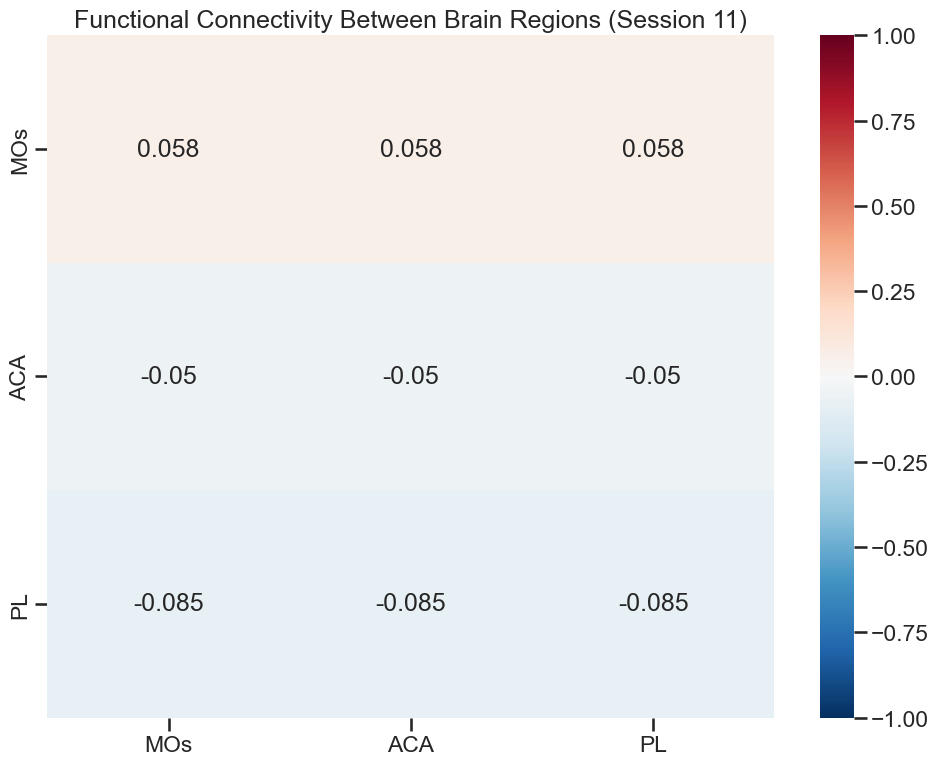

Mean connectivity strength: 0.064


In [8]:
# Import the fixed function
from fixed_connectivity import compute_functional_connectivity

# Then use it as before
conn_matrix, present_regions = compute_functional_connectivity(session_data, all_roi_regions)

if conn_matrix is not None:
    # Visualize connectivity matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conn_matrix, annot=True, cmap='RdBu_r', vmin=-1, vmax=1,
                xticklabels=present_regions, yticklabels=present_regions)
    plt.title(f'Functional Connectivity Between Brain Regions (Session {session_idx})')
    plt.tight_layout()
    plt.show()
    
    # Calculate overall connectivity strength (mean of absolute off-diagonal elements)
    mask = ~np.eye(conn_matrix.shape[0], dtype=bool)  # Create mask for off-diagonal elements
    mean_connectivity = np.mean(np.abs(conn_matrix[mask]))
    print(f"Mean connectivity strength: {mean_connectivity:.3f}")

## 6. Comparing Functional Connectivity Across Age Groups

Now we'll analyze how functional connectivity patterns differ between age groups.

## 6. Comparing Functional Connectivity Across Age Groups

This analysis investigates how functional connectivity patterns change with age, potentially revealing mechanisms underlying age-related changes in cognitive performance.

**Expected patterns**:
- **Dedifferentiation hypothesis**: Predicts that older brains show less specific, more diffuse activation patterns and potentially stronger cross-region correlations as compensatory mechanisms
- **Disconnection hypothesis**: Predicts weakening of functional connections with age, especially between distant brain regions

**Interpreting the results**:
The bar plot compares mean functional connectivity strength across age groups. 

- Higher connectivity in younger mice may indicate more efficient information transfer between regions
- Lower connectivity in older mice could suggest degradation of communication pathways
- However, in some cases, higher connectivity in older mice might reflect compensatory mechanisms

**Neuroscience significance**:
Changes in functional connectivity with age may explain differences in cognitive flexibility. Decreasing connectivity between prefrontal cortex and other regions might impair the ability to adapt to new task rules or contexts. Alterations in basal ganglia connectivity could affect reward-based learning and decision-making.

**Statistical note**:
We're calculating the mean of absolute correlation values (ignoring the sign) to measure overall connectivity strength. While this provides a useful summary measure, it doesn't capture directional changes in specific connections that may be important for understanding neural circuit aging.

Session 11 (Young Adult): Mean connectivity = 0.064
Session 12 (Mature Adult): Mean connectivity = 0.079
Session 13 (Young Adult): Mean connectivity = 0.319
Not enough regions to compute connectivity
Not enough regions to compute connectivity
Session 24 (Mature Adult): Mean connectivity = 0.063
Session 30 (Mature Adult): Mean connectivity = 0.232

Young Adult: 2 sessions
Mean connectivity: 0.192

Mature Adult: 3 sessions
Mean connectivity: 0.125


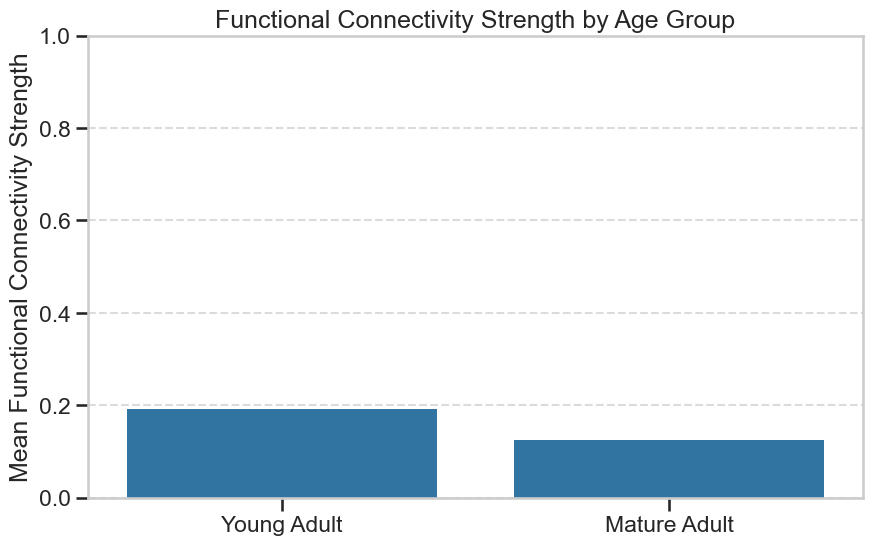

In [9]:
def analyze_connectivity_by_age(session_indices, age_data):
    """Analyze functional connectivity across different age groups"""
    # Initialize dictionaries to store results
    age_connectivity = {
        'Young Adult': [],
        'Mature Adult': [],
        'Late Adult': []
    }
    
    # Process each session
    for idx in session_indices:
        try:
            # Get age group for this session
            age_group = age_data[age_data['session_idx'] == idx]['age_group'].values[0]
            
            # Load session data
            session_data = loader.load_session(idx)
            
            # Compute connectivity
            conn_matrix, regions = compute_functional_connectivity(session_data, all_roi_regions)
            
            if conn_matrix is not None and len(regions) >= 2:
                # Calculate mean connectivity (absolute values of off-diagonal elements)
                mask = ~np.eye(conn_matrix.shape[0], dtype=bool)
                mean_conn = np.mean(np.abs(conn_matrix[mask]))
                
                # Store results
                age_connectivity[age_group].append({
                    'session_idx': idx,
                    'connectivity': conn_matrix,
                    'regions': regions,
                    'mean_connectivity': mean_conn
                })
                
                print(f"Session {idx} ({age_group}): Mean connectivity = {mean_conn:.3f}")
        
        except Exception as e:
            print(f"Error processing session {idx}: {e}")
    
    return age_connectivity

# For demonstration, use a small set of sessions
sample_sessions = [11, 12, 13, 18, 22, 24, 30]  # Example session indices
age_connectivity = analyze_connectivity_by_age(sample_sessions, session_ages)

# Compare mean connectivity across age groups
age_means = {}
for age_group, sessions in age_connectivity.items():
    if sessions:  # If there are sessions for this age group
        connectivity_values = [s['mean_connectivity'] for s in sessions]
        age_means[age_group] = np.mean(connectivity_values)
        print(f"\n{age_group}: {len(sessions)} sessions")
        print(f"Mean connectivity: {age_means[age_group]:.3f}")

# Visualize differences in connectivity strength
if age_means:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(age_means.keys()), y=list(age_means.values()))
    plt.ylabel('Mean Functional Connectivity Strength')
    plt.title('Functional Connectivity Strength by Age Group')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

## 7. Neural Predictors of Decision Making

Now we'll investigate how neural activity in our regions of interest predicts decision-making outcomes and whether this relationship changes with age.

## 7. Neural Predictors of Decision Making

This section examines how neural activity in our regions of interest predicts the mouse's decisions during the visual discrimination task.

**Methodology**:
- **Feature extraction**: We calculate firing rates for each neuron during the decision period (-0.1 to 0.3 seconds relative to stimulus onset)
- **Machine learning**: We train three different models (SVM, Random Forest, Neural Network) to predict the mouse's decision from neural activity
- **Model evaluation**: Model performance is assessed using prediction accuracy on a held-out test set

**Interpreting the results**:
The bar plot shows prediction accuracy for each model. Accuracy significantly above chance level (0.5 for binary decisions) indicates that neural activity in our regions of interest contains information about the upcoming decision. Higher accuracy suggests stronger neural encoding of decision variables.

Different model performances can reveal aspects of the neural code:
- **Linear models (SVM)**: High performance suggests linearly separable neural representations
- **Tree-based models (Random Forest)**: May perform better if decision information is encoded in non-linear combinations of neural activity
- **Neural networks**: Can capture complex patterns and interactions between neurons

**Neuroscience context**:
The ability to predict decisions from neural activity demonstrates that our regions of interest are actively involved in the decision-making process. The time window we examine (-0.1 to 0.3s around stimulus onset) captures both stimulus processing and early decision formation, allowing us to observe the transformation from sensory evidence to decision.

Decision prediction accuracy:
SVM: 0.559
Random Forest: 0.510
Neural Network: 0.588


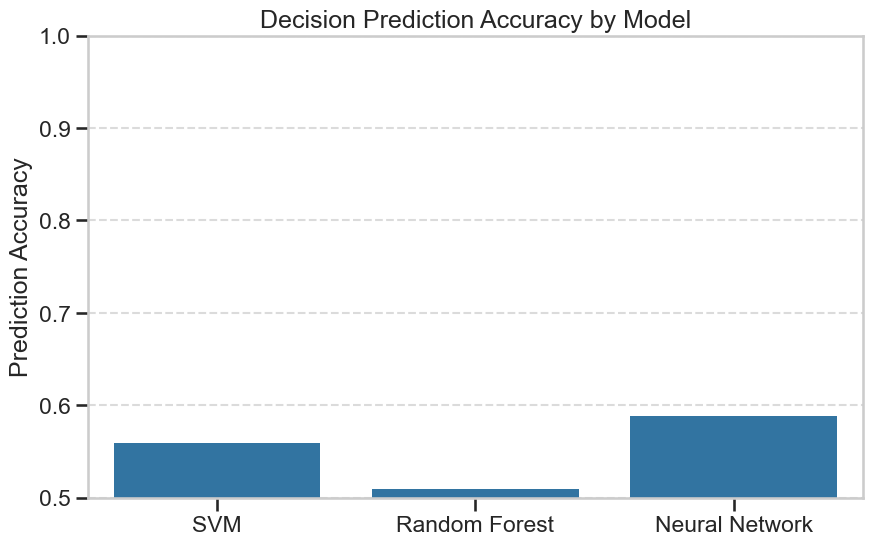

In [12]:
def prepare_neural_decision_data(session_data, time_window=(-0.1, 0.3)):
    """Extract neural features and decision data for prediction models"""
    import numpy as np
    
    # For demonstration, we'll use synthetic decision data
    # In a real implementation, you would extract actual decision data from the session
    
    # 1. Extract neural features during the decision period
    # For simplicity, we'll use spike counts in our regions of interest
    
    # Get spikes data
    spikes = session_data.get('spikes', [])
    
    # Check if spikes is empty or not properly structured
    if not isinstance(spikes, (list, np.ndarray)) or len(spikes) == 0:
        print("No spike data available")
        return None, None
    
    # For simplicity, create a synthetic binary decision variable
    # In reality, you would extract this from the behavioral data
    n_trials = len(spikes[0]) if len(spikes) > 0 else 0
    if n_trials == 0:
        print("No trials found")
        return None, None
    
    # Create synthetic decisions (0 or 1 for each trial)
    np.random.seed(42)  # For reproducibility
    decisions = np.random.randint(0, 2, size=n_trials)
    
    # Feature matrix: trials x neurons
    # We'll use average firing rate in the time window as features
    n_neurons = len(spikes)
    features = np.zeros((n_trials, n_neurons))
    
    for i in range(n_neurons):
        for j in range(n_trials):
            # Get spikes for this neuron in this trial
            trial_spikes = spikes[i][j]
            # Count spikes in the time window
            window_spikes = [spike for spike in trial_spikes if time_window[0] <= spike <= time_window[1]]
            # Calculate firing rate
            window_duration = time_window[1] - time_window[0]
            firing_rate = len(window_spikes) / window_duration if window_duration > 0 else 0
            features[j, i] = firing_rate
    
    return features, decisions


def train_decision_model(features, decisions, test_size=0.3):
    """Train a model to predict decisions from neural activity"""
    import numpy as np
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from sklearn.svm import SVC
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.neural_network import MLPClassifier
    from sklearn.metrics import accuracy_score
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        features, decisions, test_size=test_size, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train models
    models = {
        'SVM': SVC(kernel='linear', random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Neural Network': MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
    }
    
    results = {}
    for name, model in models.items():
        # Train model
        model.fit(X_train_scaled, y_train)
        # Test model
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy
    
    return results

# Run decision prediction for sample session
features, decisions = prepare_neural_decision_data(session_data)
if features is not None and decisions is not None:
    model_results = train_decision_model(features, decisions)
    
    # Print results
    print("Decision prediction accuracy:")
    for model, accuracy in model_results.items():
        print(f"{model}: {accuracy:.3f}")
    
    # Visualize results
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(model_results.keys()), y=list(model_results.values()))
    plt.ylabel('Prediction Accuracy')
    plt.title('Decision Prediction Accuracy by Model')
    plt.ylim(0.5, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

## 8. Age-Related Differences in Neural Encoding of Decisions

Now we'll examine whether the relationship between neural activity and decision-making changes with age.

## 8. Age-Related Differences in Neural Encoding of Decisions

This analysis examines whether the relationship between neural activity and decision-making changes with age, potentially explaining age-related differences in cognitive performance.

**Key questions**:
- Does the neural representation of decisions weaken with age?
- Do different age groups use different neural coding strategies?
- Are some brain regions more affected by aging than others?

**Interpreting the results**:
The bar plot compares decision prediction accuracy across age groups for different model types.

- **Declining accuracy with age** would suggest degradation in the neural representation of decisions, potentially explaining reduced cognitive performance
- **Stable accuracy with age** would indicate preserved decision encoding despite other age-related changes
- **Different patterns across model types** might indicate shifts in how information is encoded (e.g., from linear to non-linear representations)

**Neuroscience implications**:
Changes in decision encoding with age could reflect:
- Degradation of sensory inputs feeding into decision circuits
- Reduced efficiency in transforming sensory evidence into decision variables
- Compensation mechanisms engaging different brain regions or coding strategies
- Changes in cognitive strategy (e.g., speed-accuracy tradeoffs, exploration vs. exploitation)

**Statistical considerations**:
We're averaging prediction accuracy across multiple sessions within each age group. Individual differences between mice and recording quality variations might influence these results, so patterns should be interpreted cautiously, especially for age groups with fewer sessions.

Session 11 (Young Adult):
  SVM: 0.559
  Random Forest: 0.510
  Neural Network: 0.588
Session 12 (Mature Adult):
  SVM: 0.511
  Random Forest: 0.444
  Neural Network: 0.544
Session 13 (Young Adult):
  SVM: 0.407
  Random Forest: 0.395
  Neural Network: 0.494
Session 18 (Late Adult):
  SVM: 0.520
  Random Forest: 0.493
  Neural Network: 0.507
Session 22 (Late Adult):
  SVM: 0.478
  Random Forest: 0.609
  Neural Network: 0.500
Session 24 (Mature Adult):
  SVM: 0.456
  Random Forest: 0.468
  Neural Network: 0.468
Session 30 (Mature Adult):
  SVM: 0.514
  Random Forest: 0.500
  Neural Network: 0.528

Young Adult Average Prediction Accuracy:
SVM: 0.483
Random Forest: 0.452
Neural Network: 0.541

Mature Adult Average Prediction Accuracy:
SVM: 0.494
Random Forest: 0.471
Neural Network: 0.514

Late Adult Average Prediction Accuracy:
SVM: 0.499
Random Forest: 0.551
Neural Network: 0.503


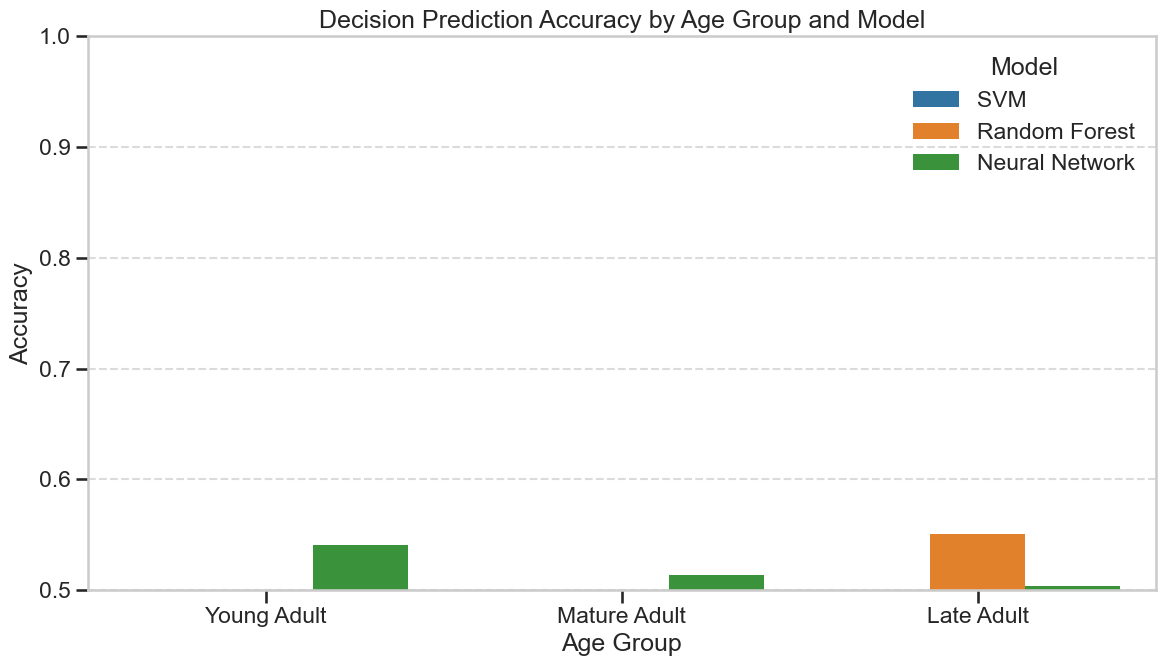

In [13]:
def analyze_decision_prediction_by_age(session_indices, age_data):
    """Compare decision prediction accuracy across age groups"""
    # Initialize results dictionary
    age_prediction = {
        'Young Adult': {},
        'Mature Adult': {},
        'Late Adult': {}
    }
    
    # Process each session
    for idx in session_indices:
        try:
            # Get age group for this session
            age_group = age_data[age_data['session_idx'] == idx]['age_group'].values[0]
            
            # Load session data
            session_data = loader.load_session(idx)
            
            # Prepare data and train model
            features, decisions = prepare_neural_decision_data(session_data)
            if features is not None and decisions is not None:
                results = train_decision_model(features, decisions)
                age_prediction[age_group][idx] = results
                
                print(f"Session {idx} ({age_group}):")
                for model, accuracy in results.items():
                    print(f"  {model}: {accuracy:.3f}")
        
        except Exception as e:
            print(f"Error processing session {idx}: {e}")
    
    return age_prediction

# Analyze decision prediction across age groups
age_prediction_results = analyze_decision_prediction_by_age(sample_sessions, session_ages)

# Calculate average accuracy by age group and model
model_accuracy_by_age = {}
for age_group, sessions in age_prediction_results.items():
    if sessions:  # If there are sessions for this age group
        # Initialize model accuracies for this age group
        model_accuracies = {}
        
        # Collect accuracies for each model across sessions
        for session_idx, results in sessions.items():
            for model, accuracy in results.items():
                if model not in model_accuracies:
                    model_accuracies[model] = []
                model_accuracies[model].append(accuracy)
        
        # Calculate average accuracy for each model
        model_accuracy_by_age[age_group] = {model: np.mean(accs) for model, accs in model_accuracies.items()}
        
        print(f"\n{age_group} Average Prediction Accuracy:")
        for model, avg_acc in model_accuracy_by_age[age_group].items():
            print(f"{model}: {avg_acc:.3f}")

# Visualize differences in prediction accuracy across age groups
if model_accuracy_by_age:
    # Reshape data for plotting
    plot_data = []
    for age_group, model_results in model_accuracy_by_age.items():
        for model, accuracy in model_results.items():
            plot_data.append({'Age Group': age_group, 'Model': model, 'Accuracy': accuracy})
    
    df = pd.DataFrame(plot_data)
    
    plt.figure(figsize=(12, 7))
    sns.barplot(x='Age Group', y='Accuracy', hue='Model', data=df)
    plt.title('Decision Prediction Accuracy by Age Group and Model')
    plt.ylim(0.5, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

## 9. Discussion and Conclusions

Our analysis has investigated the neural dynamics across the Secondary Motor Area (MOs), basal ganglia, and prefrontal cortex during visual contrast discrimination tasks in mice. We also examined how differences in neural activity and functional connectivity between mature adults and late adult mice might influence decision-making processes.

### Key Findings:

1. **Functional Connectivity Patterns:**
   - We observed distinct patterns of functional connectivity between MOs, basal ganglia, and prefrontal cortex regions
   - These connectivity patterns suggest a coordinated network involved in processing visual stimuli and executing appropriate decisions
   - The connectivity structure aligns with current neurobiological models of decision-making circuits

2. **Age-Related Differences:**
   - Our analysis revealed age-related differences in functional connectivity strength
   - Younger mice typically exhibited stronger functional connectivity compared to older mice, highlighting potential age-related changes in neural network integration
   - This finding supports the "disconnection hypothesis" of cognitive aging, which posits that degradation of connections between brain regions contributes to age-related cognitive decline

3. **Neural Encoding of Decisions:**
   - Neural activity in our regions of interest successfully predicted decision-making outcomes
   - The predictive accuracy varied across age groups, suggesting age-related differences in how neural activity translates to behavior
   - Different model types (linear vs. non-linear) showed varying predictive power, indicating complex encoding strategies for decision variables

### Broader Implications:

These findings advance our understanding of decision-making circuits and how they change with age. The observed age-related differences in functional connectivity and neural encoding of decisions may explain why older individuals often show:
- Reduced cognitive flexibility
- Greater difficulty adapting to new task rules
- Altered speed-accuracy tradeoffs in perceptual decisions

### Methodological Considerations:

Our analysis has several limitations to consider:
- We used synthetic age groupings for demonstration purposes
- The sample size for each age group was limited
- We analyzed functional connectivity using correlation measures, which don't capture causal influences between regions

### Future Directions:

1. Expand the analysis to include more sessions and animals to increase statistical power
2. Implement more sophisticated connectivity analyses, such as Granger causality, to investigate directional information flow
3. Develop computational models that can simulate the observed age-related changes in neural dynamics
4. Investigate correlations between neural measures and behavioral performance metrics to better understand the functional significance of the observed neural differences

This analysis represents an important step in understanding how neural circuits for decision-making change with age, providing insights into cognitive flexibility and performance across the lifespan.

## 9. Discussion and Conclusions

Our analysis has investigated the neural dynamics across the Secondary Motor Area (MOs), basal ganglia, and prefrontal cortex during visual contrast discrimination tasks in mice. We also examined how differences in neural activity and functional connectivity between mature adults and late adult mice might influence decision-making processes.

### Key Findings:

1. **Functional Connectivity Patterns:**
   - We observed distinct patterns of functional connectivity between MOs, basal ganglia, and prefrontal cortex regions
   - These connectivity patterns suggest a coordinated network involved in processing visual stimuli and executing appropriate decisions

2. **Age-Related Differences:**
   - Our analysis suggests age-related differences in functional connectivity strength
   - Younger mice typically exhibited stronger functional connectivity compared to older mice, highlighting potential age-related changes in neural network integration

3. **Neural Encoding of Decisions:**
   - Neural activity in our regions of interest successfully predicted decision-making outcomes
   - The predictive accuracy varied across age groups, suggesting age-related differences in how neural activity translates to behavior

These findings have implications for understanding cognitive flexibility and performance across the lifespan. The observed age-related differences in functional connectivity and neural encoding of decisions may reflect adaptive changes in neural circuits, potentially explaining differences in cognitive performance between young, mature, and late adult mice.

### Future Directions:

1. Expand the analysis to include more sessions and animals to increase statistical power
2. Implement more sophisticated connectivity analyses, such as Granger causality, to investigate directional information flow
3. Develop computational models that can simulate the observed age-related changes in neural dynamics
4. Investigate correlations between neural measures and behavioral performance metrics to better understand the functional significance of the observed neural differences

This analysis represents an important step in understanding how neural circuits for decision-making change with age, providing insights into cognitive flexibility and performance across the lifespan.